In [23]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

In [24]:
df = pd.read_csv('/content/train_data.csv')
Gender = df['gender'].values
df.head()

,gender,age,fullname,username,biography,follower_count,following_count,is_business,is_verified,is_private
0,man,2,Farshid,mr_gh_farshid,دردا ک در این بادیه بسیار دویدیم...\nGlory man...,1604.0,1407.0,0.0,0.0,0.0
1,woman,2,zahr@72,zahra.roozbahani72,"خواهی که زکوچ در امان برگردی\nباید که به جان ,...",67.0,501.0,0.0,0.0,0.0
2,woman,2,ms farahnaz♥,___lady.farahnazi.__,"Having you, is all I wish for \nداشتنت، تمامِ...",0.0,0.0,0.0,0.0,0.0
3,woman,1,Lena.mommy farzan,mommy.lena3361,دردونه من لنا کوچولو,0.0,0.0,0.0,0.0,0.0
4,woman,2,Narsis Asadollahi,_l.aurora.l_,I am an animation student\n🎧🎼🎨⚓️🤍 \n@general.m...,200.0,328.0,0.0,0.0,0.0


## Binary to bipolar

In [25]:
df[['is_business','is_verified','is_private']] = df[['is_business','is_verified','is_private']].replace(0,-1)

## Functions

In [26]:
def feature_vectorizer(df,feature, max_feature=None):
    name = df[feature].tolist()
    if max_feature==None:
            vectorizer = TfidfVectorizer()
    else:
        vectorizer = TfidfVectorizer(max_features=max_feature)

    result = vectorizer.fit_transform(name)
    result = result.toarray()
    return result

def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result   

## Normalizing features

In [27]:
df[['age','follower_count', 'following_count']] = normalize(df[['age','follower_count', 'following_count']])

## One Hot Encoding

In [28]:
dummies = pd.get_dummies(df[['gender']])
df = pd.concat([df, dummies], axis=1)
df = df.drop(['gender'], axis=1)
df[['follower_count', 'following_count','is_business','is_verified','is_private']].values.shape

(8000, 5)

## Vectorizing features

In [29]:
age_v = df['age'].values.reshape((df.shape[0],1))
feature1 = feature_vectorizer(df,'fullname',10)
feature2 = feature_vectorizer(df,'username',10)
feature3 = feature_vectorizer(df,'biography',150)
end_v = df[['follower_count', 'following_count','is_business','is_verified','is_private']].values.reshape((df.shape[0],-1))
X_train =np.concatenate((age_v,feature1,feature2,feature3,end_v),axis = 1)
X_train.shape

(8000, 176)

## Filling nans with zeros

In [30]:
print("Check NaNs: ",np.unique(np.isnan(X_train)))
print("number of NaNs: ",np.count_nonzero(X_train))
print("location of NaNs: ",np.argwhere(np.isnan(X_train)))
X_train[np.isnan(X_train)] = 0

Check NaNs:  [False  True]
number of NaNs:  62286
location of NaNs:  [[4389  173]
 [4980  173]
 [5016  173]]


In [31]:
df = df.astype({'gender_man':'float','gender_woman':'float'})
Y_train = df[['gender_man', 'gender_woman']].values

## checking data distribution

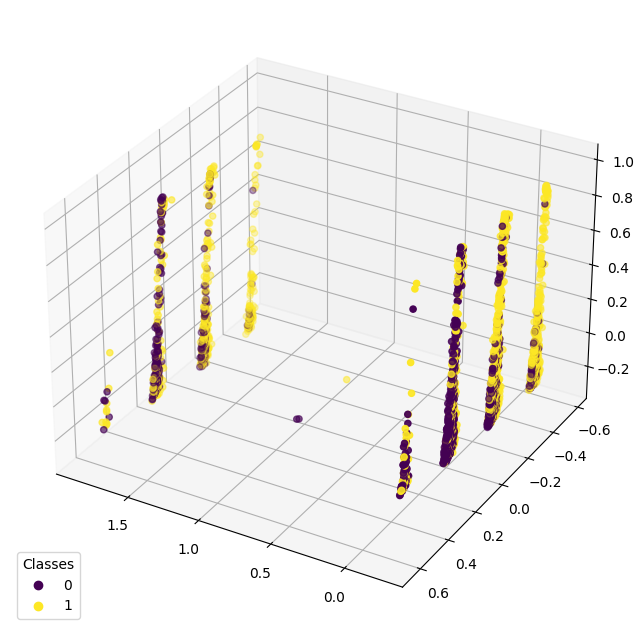

In [38]:
from sklearn.decomposition import PCA
Gender[np.where(Gender=='man')] = 1
Gender[np.where(Gender=='woman')] = 0

pca = PCA(n_components=3)
D = pca.fit_transform(X_train)
fig = plt.figure(figsize=[8,8])
ax  = fig.add_subplot(111, projection='3d')
ax.view_init(30, 120)
SCAT = ax.scatter(D[:,0],D[:,1],D[:,2],c=Gender)
ax.legend(*SCAT.legend_elements(),
                    loc="lower left", title="Classes")
plt.show()


## MLP

In [19]:
class MultilayerPerceptron():

  def __init__(self, data, label, n_input, n_hidden, n_output, alpha):
    self.data = data
    self.t = label                                                        # target
    self.n_input = n_input                                                # num of 1st layer neurons
    self.n_hidden = n_hidden                                              # num of hidden layer neurons
    self.alpha = alpha                                                    # learning rate
    limit   = 1 / math.sqrt(n_input)
    self.V  = np.random.uniform(-limit, limit, (n_input, self.n_hidden))
    self.v0 = np.random.uniform(-limit, limit, (1, self.n_hidden))
    limit   = 1 / math.sqrt(self.n_hidden)
    self.W  = np.random.uniform(-limit, limit, (self.n_hidden, n_output)) 
    self.w0 = np.random.uniform(-limit, limit, (1, n_output))
  
  def sigmoid(self, input):
    return 1/(1+np.exp(-input))

  def dsigmoid(self, input):
    return self.sigmoid(input) * (1- self.sigmoid(input))

  def RELU(self,input):
    return(np.maximum(0, input))

  def dRELU(self,input):
    input[input<=0] = 0
    input[input>0] = 1
    return input

  def Loss(self, Y):
    Y = np.clip(Y, 1e-10, 1.)
    return np.mean(-self.t * np.log10(Y) - (1 - self.t) * np.log10(np.clip(1 - Y, 1e-10, 1.)), dtype=np.float64) 


  def ForwardBackward(self, X, t):
    z_in = np.dot(X, self.V) + self.v0
    z = self.RELU(z_in)
    y_in = np.dot(z, self.W) + self.w0
    y = self.sigmoid(y_in)           
    
    delta1 = t-y 
    delta_in = np.dot(delta1, self.W.T)     
    delta = delta_in*self.dRELU(z_in)
   
    self.W += self.alpha * np.dot(z.T, delta1)      
    self.w0 += self.alpha * delta1
    X = X.reshape(self.n_input, 1)                                    
    self.V += self.alpha * np.dot(X, delta)
    self.v0 += self.alpha * delta
    y = y.flatten()
    return y 


  def epoch(self,max_epochs):
      import time    
      start_time = time.time()
      AccList = []
      LossList = []
      for epoch in range(max_epochs):
              predList = []
              for (sample,target) in zip(self.data, self.t):
                  pred = model.ForwardBackward(sample,target)
                  predList.append(pred)
              predArr = np.stack(predList,axis=0)
              LossList.append(model.Loss(predArr))
              AccList.append(model.Acc(predArr,self.t))
              print("epoch-",epoch+1," Loss: ", model.Loss(predArr))
              if epoch == max_epochs-1:
                    acc = model.Acc(predArr,self.t)
                    print("train accuracy: ", np.around(acc*100,decimals=4),'%')

      print('Durationt: ',np.around(time.time() - start_time,decimals=4),' seconds')
      print()

      plt.figure(figsize=[8,6])
      epochs = [i for i in range(max_epochs)]
      plt.plot(epochs, np.array(AccList)*100, 'b')
      plt.legend(['Training accuracy'], fontsize=18)
      plt.title('ACC&Losss-epoch')
      plt.xlabel('Epochs',fontsize=16)
      plt.ylabel('Acc%',fontsize=16)

      plt.figure(figsize=[8,6])
      plt.plot(epochs, LossList, 'r')
      plt.legend(['Training loss'], fontsize=18)
      plt.xlabel('Epochs',fontsize=16)
      plt.ylabel('Loss',fontsize=16)   


  
  def predict(self, X):
    z_in = np.dot(X, self.V) + self.v0
    z = self.RELU(z_in)
    y_in = np.dot(z, self.W) + self.w0
    y = self.sigmoid(y_in)
    return y

  def Acc(self,Y,labels):
    Y[Y>0.9]=1.
    Y[Y<0.1]=0.
    TPTN = np.sum(np.all(Y == labels, axis=1))
    acc = TPTN / labels.shape[0]
    return acc

In [20]:
model = MultilayerPerceptron(X_train, Y_train, n_input=176,
                             n_hidden=89,
                             n_output=2,alpha=0.01)

epoch- 1  Loss:  0.2706942244643807
epoch- 2  Loss:  0.26635088499426446
epoch- 3  Loss:  0.2602483463196311
epoch- 4  Loss:  0.25663060227430023
epoch- 5  Loss:  0.25408953777709187
epoch- 6  Loss:  0.2555145214358038
epoch- 7  Loss:  0.25803652228326385
epoch- 8  Loss:  0.2552795902567876
epoch- 9  Loss:  0.2565876771532023
epoch- 10  Loss:  0.25677221634105746
epoch- 11  Loss:  0.2571884435560115
epoch- 12  Loss:  0.25697171348880843
epoch- 13  Loss:  0.26003786250203176
epoch- 14  Loss:  0.25403897547473103
epoch- 15  Loss:  0.25280346910556534
epoch- 16  Loss:  0.25630944783090215
epoch- 17  Loss:  0.25708505630574313
epoch- 18  Loss:  0.24904978194898358
epoch- 19  Loss:  0.2537927555694759
epoch- 20  Loss:  0.2521334491803113
epoch- 21  Loss:  0.25185380850714223
epoch- 22  Loss:  0.2507314500596291
epoch- 23  Loss:  0.25380757463675074
epoch- 24  Loss:  0.254468931494925
epoch- 25  Loss:  0.2541799522741926
epoch- 26  Loss:  0.25886017769896613
epoch- 27  Loss:  0.2590299669558

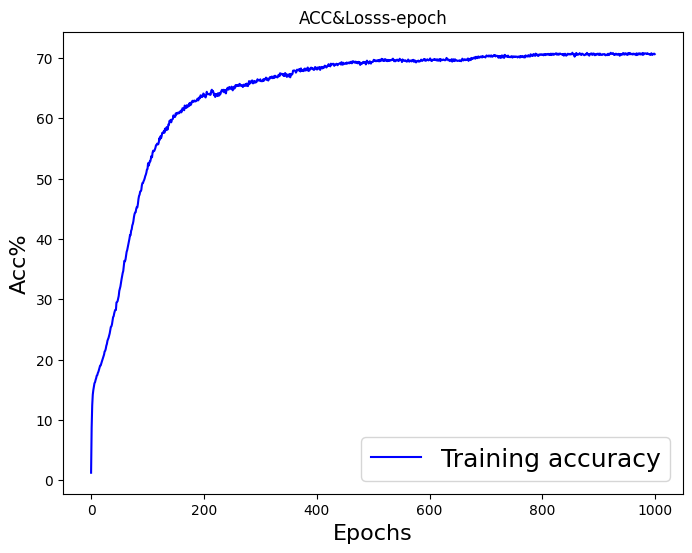

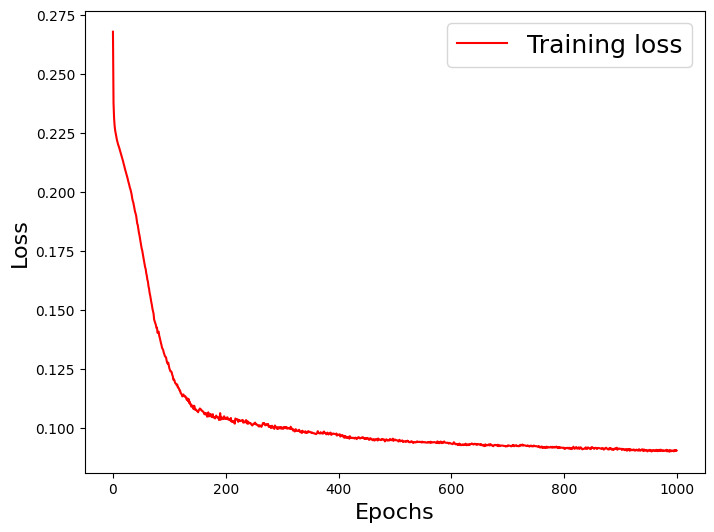

In [21]:
model.epoch(1000)

## Test dataset without labels

In [39]:
DF = pd.read_csv('/content/test_data.csv')
DF.head()

,age,fullname,username,biography,follower_count,following_count,is_business,is_verified,is_private
0,2,Mehrnoosh Rahimi,mehrnoosh_hooka,🕉♋️\n 🎂 Mehr🎂\nگرچه بنی ادم اعضای یک پیکر اند\...,791.0,174.0,0.0,0.0,0.0
1,4,Mehdi,mehdil_eng,"Civil engineer(Shiraz Uni) , Book , Travel...",0.0,0.0,0.0,0.0,0.0
2,2,MohammadHossein ahmadizadeh,madh0sin,(به نام‌خدایی‌که داده اش‌نعمت‌است‌ونداده اش حک...,1902.0,3436.0,1.0,0.0,0.0
3,1,Sara Noori,saray_nri,▪️UI,114.0,173.0,0.0,0.0,0.0
4,2,Shi Ma,shima_syd,Lives in turkey\nThe married 👫💑👪,0.0,0.0,0.0,0.0,0.0


In [40]:
DF[['is_business','is_verified','is_private']] = DF[['is_business','is_verified','is_private']].replace(0,-1)
DF[['age','follower_count', 'following_count']] = normalize(DF[['age','follower_count', 'following_count']])

In [41]:
feature1 = feature_vectorizer(DF,'fullname',10)
feature2 = feature_vectorizer(DF,'username',10)
feature3 = feature_vectorizer(DF,'biography',150)
age_v = DF['age'].values.reshape((DF.shape[0],1))
end_v = DF[['follower_count', 'following_count','is_business','is_verified','is_private']].values.reshape((DF.shape[0],-1))
X_test = np.concatenate((age_v,feature1,feature2,feature3,end_v),axis = 1)

In [42]:
print("Check NaNs: ",np.unique(np.isnan(X_test)),"number of NaNs: ",np.count_nonzero(X_test),"location of NaNs: ",np.argwhere(np.isnan(X_test)))

Check NaNs:  [False] number of NaNs:  15667 location of NaNs:  []


In [43]:
X_test[np.isnan(X_test)] = 0

## Random labelling

In [44]:
Lables = np.concatenate((np.ones(1000, dtype = float), np.zeros(1000, dtype = float)))
np.random.shuffle(Lables)
men_lables = Lables.copy()
where_1 = np.where(Lables == 1.)
where_0 = np.where(Lables == 0.)
Lables[where_0] = 1.
Lables[where_1] = 0.

women_lables = Lables
DF["gender_man"] = men_lables
DF['gender_woman']= women_lables


Y_PRED = model.predict(X_test)
TAR = DF[['gender_man', 'gender_woman']].values

print("Test Accuracy:",model.Acc(Y_PRED,TAR)*100.)

Test Accuracy: 30.0


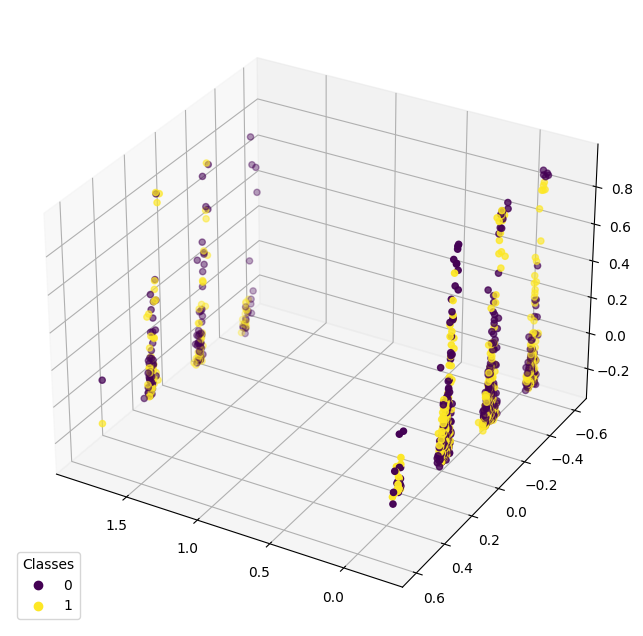

In [46]:
pca = PCA(n_components=3)
D = pca.fit_transform(X_test)
fig = plt.figure(figsize=[8,8])
ax  = fig.add_subplot(111, projection='3d')
ax.view_init(30, 120)
SCAT = ax.scatter(D[:,0],D[:,1],D[:,2],c=np.where(TAR == 1)[1])
ax.legend(*SCAT.legend_elements(),
                    loc="lower left", title="Classes")
plt.show()